# Getting Started: Pixel-Level Segmentation (Task 2)

This notebook walks through the process of loading in the volume cutouts from BossDB (with visualization), training UNet, and evaluating the model with performance metrics.

### Installing Required Packages

In [1]:
# Download and install Pytorch for CUDA 10.2
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu102
# Download and install Pytorch for CUDA 11.3
!pip install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113
    
!pip install intern
!pip install scikit-learn
!pip install timm
!pip install pretrainedmodels
!pip install efficientnet_pytorch

# Setting up the segmentation_models.pytorch library
!pip install github-clone
!ghclone https://github.com/qubvel/segmentation_models.pytorch/tree/master/segmentation_models_pytorch 
!cp -rf segmentation_models_pytorch ../MTNeuro/.
!rm -rf segmentation_models_pytorch


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu102
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
  Created wheel for intern: filename=intern-1.3.1-py2.py3-none-any.whl size=153066 sha256=59ce63a2de0907b28e99aac73b5ccb6fbba874f5ded494d67ba361024bced448
  Stored in directory: c:\users\christopher liding\appdata\local\pip\cache\wheels\71\3f\de\2e61fa2596d1a1ffa433ed5fb09977d87cb4c04063919a8989
Successfully built intern
  Using cached pretrainedmodels-0.7.4.tar.gz (58 kB)
  Using cached munch-2.5.0-py2.py3-none-any.whl (10 kB)
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=b3202ff6657317d2172cb61cfeec4f9284adcf1ced412d6093e07eee9b9b5a2a
  Stored in directory: c:\users\christopher liding\appdata\local\pip\cache\wheels\d1\3b\4e\2f3015f1ab76f34be28e04c4bcee27e8cabfa70d2eadf8bc3b
Successfully built pretrainedmodels
  Using cached efficientnet_pytorch-0.7.1.tar.gz (21

'cp' is not recognized as an internal or external command,
operable program or batch file.
'rm' is not recognized as an internal or external command,
operable program or batch file.


### Importing Required Modules


In [2]:
# Import libraries and set random seed
import sys
import matplotlib.pyplot as plt
import numpy as np
import json as json
from tqdm import tqdm

# Pytorch imports
import torch
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid

sys.path.append('../MTNeuro/')                 #setting the location to look for the required packages
# BossDB library and MTNeuro dataset loader
from intern import array
from bossdbdataset import BossDBDataset               

from trainer import Trainer                    #trainer function used to train the models
from models.unet import UNet                          #UNet model. From: https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial
import segmentation_models_pytorch as smp      #SMP library (used for calculation of performance metrics: https://github.com/qubvel/segmentation_models.pytorch

from sklearn.metrics import ConfusionMatrixDisplay

torch.manual_seed(0)
np.random.seed(0)

### Loading the Preset Configurations for Training our PyTorch Model

The configurations necessary to train our models are located at ../MTNeuro/taskconfig/. We load them in automatically here.

The dimension of the dataset and the number of classes for this segmentation task determines which configurations file to load.
- The dimension of the volume cutouts can either be 2D or 3D.
- A 3-class setting will segment the volume cutouts to Blood Vessels, Cells, and Background + Axons.
- A 4-class setting will segment the volume cutouts to Blood Vessels, Cells, Axons, and Background.

Run only **one** of the following four cells:


#### Training a 2D Model in a 4-Class Setting

In [3]:
# Load the task config for 2D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_2D_4class.json'))

# Load the network config for the 2D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_2D_4class.json'))

#### Training a 2D model in a 3-Class Setting 

In [24]:
# Load the task config for 2D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_2D_3class.json'))

# Load the network config for the 2D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_2D_3class.json'))

#### Training a 3D model in a 4-Class Setting 

In [64]:
# Load the task config for 3D 4-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_3D_4class.json'))

# Load the network config for the 3D model for 4-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_3D_4class.json'))

#### Training a 3D model in a 3-Class Setting 

In [55]:
# Load the task config for 3D 3-class setting that specifies the x,y ranges to pick from the data for forming the slices
task_config = json.load(open('../MTNeuro/taskconfig/task2_3D_3class.json'))

# Load the network config for the 3D model for 3-class setting, with the batch size and model config information
network_config = json.load(open('../MTNeuro/networkconfig/UNet_3D_3class.json'))

### Loading the Volume Cutouts with the BossDB Dataloader

We use [Intern](https://pypi.org/project/intern/), which is an API that allows us to access the data on-demand.

An optional transformation of the data cutouts can be specified here.

In [4]:
# Specify the transformations here:

# transform = ...

# If no transformations are used:
transform = transforms.Compose([transforms.ToTensor(),])

# Download the volume cutouts from BossDB and set-up the train and validation dataloaders
train_data =  BossDBDataset(task_config, None, 'train', image_transform = transform, mask_transform = transform)
val_data = BossDBDataset(task_config, None, 'val', image_transform = transform, mask_transform = transform)

train_dataloader = DataLoader(dataset=train_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
validation_dataloader = DataLoader(dataset=val_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)

#### Volume Cutout Descriptions

In [5]:
#Access the input and the groundtruth annotations of the first batch
x,y = next(iter(train_dataloader))

#Shape of the batch
print(f'Shape of x: {x.shape}; Type: {x.dtype}')
print(f'Minimum value of x: {x.min()}; Maximum value of x: {x.max():.4f}')
print(f'Shape of y: {y.shape}; Possible classes: {y.unique()}; Type: {y.dtype}')
print(f'Minimum value of y: {y.min()}; Maximum value of y: {y.max()}')

Shape of x: torch.Size([8, 1, 256, 256]); Type: torch.float32
Minimum value of x: 0.0; Maximum value of x: 0.9490
Shape of y: torch.Size([8, 256, 256]); Possible classes: tensor([0, 1, 2]); Type: torch.int64
Minimum value of y: 0; Maximum value of y: 2


### Data Visualization

#### Visualizing the First Slice from the First Batch and Its Groundtruth Annotation


Text(0.5, 1.0, 'Its Groundtruth Annotation')

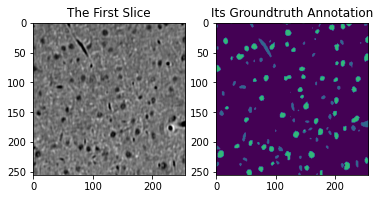

In [6]:
plt.subplot(1,2,1)
plt.imshow(x.squeeze()[0], cmap='gray')
plt.title("The First Slice")
plt.subplot(1,2,2)
plt.imshow(y.squeeze()[0], vmin=0, vmax=3)
plt.title("Its Groundtruth Annotation")

#### A Collage of Random Slices from the Training Data

Text(0.5, 1.0, 'A Collage of 100 Random Slices')

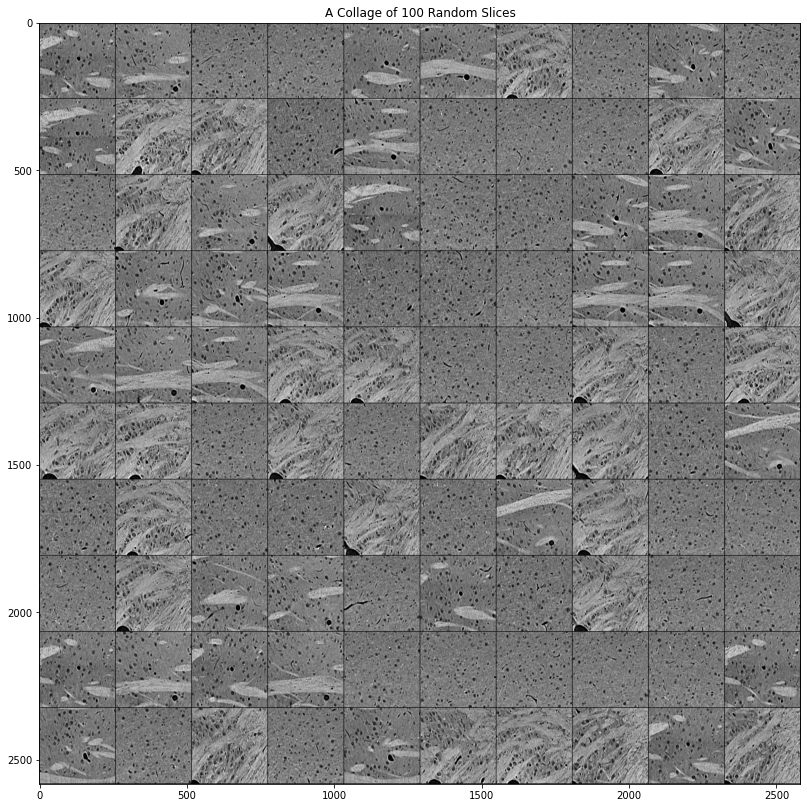

In [7]:
import random

# Reshape data and select a random subset of 100 slices
if network_config['dim']==3:
    reshaped_data = []
    for data in train_data:
        reshaped_data = reshaped_data + list(data[0][0])

#    
##    reshaped_data = torch.reshape(torch.stack([data[0][0] for data in train_data]), shape=(-1, 256, 256))
 ##   perm = torch.randperm(reshaped_data.size(0))
 #   idx = perm[:100]
 #   reshaped_data = reshaped_data[idx]
if network_config['dim']==2:
    #reshaped_data = torch.reshape(torch.stack(random.sample([data[0][0] for data in train_data], 100)), shape=(-1,256, 256))
    reshaped_data = [data[0][0] for data in train_data]
random_samples_from_data = random.sample(reshaped_data,100)
    
grid_img = make_grid(torch.stack(random_samples_from_data).unsqueeze(1), nrow=10)
plt.figure(figsize=(14,14))
plt.imshow(grid_img[0], cmap='gray')
plt.title("A Collage of 100 Random Slices")

### Importing the Model

For this notebook, we use the [U-Net](https://github.com/johschmidt42/PyTorch-2D-3D-UNet-Tutorial) model as an example to demonstrate model training and evaluation.


In [8]:
# Specify the device to run the model on
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Load the model with the configuration specified through the previously loaded in network configurations file.
print('Loading UNet model')
model = UNet(in_channels=network_config['in_channels'],
            out_channels=network_config['classes'],
            n_blocks=network_config['n_blocks'],
            start_filters=network_config['start_filters'],
            activation=network_config['activation'],
            normalization=network_config['normalization'],
            conv_mode=network_config['conv_mode'],
            dim=network_config['dim']).to(device)
print('Done!')

Loading UNet model
Done!


### Setting the Loss Function and the Optimizer

In [9]:
# Loss criterion
criterion = torch.nn.CrossEntropyLoss()

# Optimizer (picks the required information from the network config file)
if network_config["optimizer"] == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), lr=network_config["learning_rate"])
if network_config["optimizer"] == "Adam":
    optimizer = torch.optim.Adam(model.parameters(), lr=network_config["learning_rate"], betas=(network_config["beta1"],network_config["beta2"]))
 

### Training the Model

In [10]:
# Configure the trainer
trainer = Trainer(model=model,
                    device=device,
                    criterion=criterion,
                    optimizer=optimizer,
                    training_DataLoader=train_dataloader,
                    validation_DataLoader=validation_dataloader,
                    lr_scheduler=None,
                    epochs=network_config["epochs"],
                    notebook=True)

# Start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


Progress:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

Training:   0%|          | 0/101 [00:00<?, ?it/s]

Validation:   0%|          | 0/11 [00:00<?, ?it/s]

### Evaluating the Model

In [13]:
# Function to predict using trained model
def predict(img, model, device):
        model.eval()
        x = img.to(device)            #send input to device
        with torch.no_grad():
            out = model(x)            #model forward pass

        out_argmax = torch.argmax(out, dim=1)  #perform softmax on outputs
        return out_argmax

#### Loading in Test Data and Predicting

In [14]:
# Load the test data
test_data =  BossDBDataset(task_config, None, "test", image_transform = transform, mask_transform = transform)
test_dataloader = DataLoader(dataset=test_data,
                                        batch_size=network_config['batch_size'],
                                        shuffle=False)
 
batch_iter = tqdm(enumerate(test_dataloader), 'test', total=len(test_dataloader), leave=False)

# Variables for storing the True Postive, False Positive, False Negative and True Negative scores respectively
tp_tot = torch.empty(0,network_config['classes'])
fp_tot = torch.empty(0,network_config['classes'])
fn_tot = torch.empty(0,network_config['classes'])
tn_tot = torch.empty(0,network_config['classes'])

# Predict on test data
for i, (x, y) in batch_iter:
    target = y.to(device) #can do this on CPU
    with torch.no_grad():
        #pass the input image through the model and get the output image
        output = predict(x, model, device)
        #calculate the true positive, false positive and false negative
        tp, fp, fn, tn = smp.metrics.get_stats(output, target, mode='multiclass', num_classes = network_config['classes'])
        tp_tot = torch.vstack((tp_tot,tp))
        fp_tot = torch.vstack((fp_tot,fp))
        fn_tot = torch.vstack((fn_tot,fn))
        tn_tot = torch.vstack((tn_tot,tn))

#### Visualizing Model Predictions

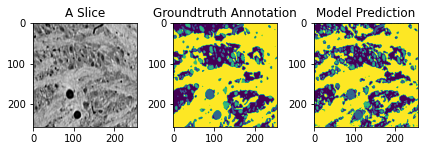

In [24]:
plt.subplot(1,3,1)
plt.imshow(x.squeeze()[0], cmap='gray')
plt.title("A Slice")
plt.subplot(1,3,2)
plt.imshow(y.squeeze()[0], vmin=0, vmax=3)
plt.title("Groundtruth Annotation")
plt.subplot(1,3,3)
plt.imshow(output.squeeze()[0], vmin=0, vmax=3)
plt.title("Model Prediction")
plt.tight_layout()

#### Calculating Performance Metrics

Metric Calculations:
- Accuracy: $\frac{tp + fp}{fp + tn + fn + tp}$
- Balanced Accuracy: $\frac{Specificity + Sensitivity}{2}$
- F1-Score: $\frac{2\times precision \times recall}{precision + recall}$
- IoU: $\frac{tp}{fp + fn + tp}$

Where tp = true positive, tn = true negative, fp = false positive, and fn = false negative.

In [23]:
# Accuracy
acc = (tp_tot.mean(dim=0)+tn_tot.mean(dim=0))/(fp_tot.mean(dim=0)+tn_tot.mean(dim=0)+fn_tot.mean(dim=0)+tp_tot.mean(dim=0)) 
print('new Accuracy per Class:')
print(np.array(acc.cpu()))

# Balanced Accuracy
spec =  (tn_tot[:,1:].mean())/(fp_tot[:,1:].mean()+tn_tot[:,1:].mean())
sens =  (tp_tot[:,1:].mean())/(fn_tot[:,1:].mean()+tp_tot[:,1:].mean())
balacc = (spec + sens)/2
print(f'new Balanced accuracy (No background): {balacc}')

# F1-score
prec = tp_tot.mean(dim=0)/(fp_tot.mean(dim=0)+tp_tot.mean(dim=0))
reca = tp_tot.mean(dim=0)/(fn_tot.mean(dim=0)+tp_tot.mean(dim=0))
f1 = (2*reca*prec)/(reca+prec)
print(f'new F1-score: {np.array(f1.cpu())} Avg. F1-score: {f1.mean()}')

# IoU
iou = (tp_tot.mean(0))/(fp_tot.mean(0)+fn_tot.mean(0)+tp_tot.mean(0))
print(f'new IoU: {np.array(iou.cpu())} Avg. IoU-score: {iou.mean()}')

new Accuracy per Class:
[0.8123111 0.9761211 0.9701239 0.8403296]
new Balanced accuracy (No background): 0.8844213485717773
new F1-score: [0.8428934  0.54863006 0.6983373  0.75563115] Avg. F1-score: 0.7113730311393738
new IoU: [0.7284492 0.3780084 0.5364964 0.6072405] Avg. IoU-score: 0.5625486373901367
